<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-03-tree-based-models-bagging-cforest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.3 Conditional Random Forest (cforest)

Conditional Random Forest (cforest) builds on ensemble learning method that constructs multiple decision trees but uses **conditional inference trees** (implemented via the `ctree` algorithm) instead of standard CART (Classification and Regression Trees). These trees are based on a statistical framework that tests the independence between predictors and the response variable to guide splitting decisions. This notebook will cover the theoretical background, implementation details, and practical applications of cforest with Python.

## Overview

A **Conditional Random Forest (cforest)** is an extension of the Random Forest algorithm that uses **conditional inference trees** as its base learners instead of standard decision trees. It was introduced to address some limitations of traditional Random Forests, particularly in handling variable selection bias and providing more robust statistical inference. The `cforest` algorithm is implemented in the R package `party` and is designed to work within a conditional inference framework, which ensures unbiased variable selection and better handling of complex data structures.

Key Features of cforest:

-   `Unbiased Variable Selection`: Unlike traditional Random Forests, which may favor variables with more categories or continuous variables, cforest uses conditional inference to select variables without bias.

-   `Statistical Rigor`: It incorporates permutation-based significance tests to decide splits, making it more robust for datasets with complex relationships or correlated predictors.

-`Flexibility`: cforest can handle various types of response variables (e.g., continuous, categorical, survival data) and is less sensitive to overfitting in certain scenarios.


### How Does Conditional Random Forest (cforest) Work?

The **Conditional Random Forest (cforest)** algorithm combines the ensemble approach of Random Forests with the **conditional inference framework** to reduce bias in variable selection and handle mixed data types effectively. Below is a detailed explanation, incorporating mathematical formulations where relevant:

1. Input Data

-   `Dataset`: Let $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$ be the dataset, where:

  -   $\mathbf{x}_i = (x_{i1}, x_{i2}, \dots, x_{ip})$ is a vector of $p$ predictor variables (numeric or categorical).

  -   $y_i$ is the response variable (continuous for regression, categorical for classification).

-   The goal is to predict $y$ given $\mathbf{x}$ using an ensemble of conditional inference trees.

2. Bootstrapping or Subsampling

-   `Bagging`: For each tree $t = 1, 2, \dots, T$, a bootstrap sample $D_t$ is drawn from $D$ with replacement, typically of size $n$. The probability that a specific observation $(\mathbf{x}_i, y_i)$ is included in $D_t$ is approximately $1 - (1 - 1/n)^n \approx 1 - e^{-1} \approx 0.632$.

-   `Subsampling`: Alternatively, a random subset of size $m< n$ is drawn without replacement. This reduces correlation between trees compared to bagging.

-   `Out-of-Bag (OOB) Sample`: Observations not included in $D_t$ form the OOB sample, used for estimating generalization error.

3.  Building Conditional Inference Trees

Each tree in cforest is a **conditional inference tree** (`ctree`), constructed using a statistical framework to ensure unbiased variable selection. The process involves:

3.1  `Variable Selection via Conditional Inference`:

  -   At each node, cforest tests the null hypothesis $H_0: Y \perp X_j \mid \mathbf{X}_{-j}$ for each predictor $X_j$, where $\mathbf{X}_{-j}$ denotes all other predictors.

    -   The test is based on a `permutation test`:

        -   Compute a test statistic (e.g., for regression, a correlation-based statistic; for classification, a chi-squared or Gini-based statistic).

        -   Permute the values of $X_j$ while keeping $Y$ and $\mathbf{X}_{-j}$ fixed to generate a null distribution.

        -   Calculate the p-value as the proportion of permuted test statistics exceeding the observed statistic:

$$  p_j = P(T(\mathbf{X}_j^{\text{perm}}, Y) \geq T(\mathbf{X}_j, Y) \mid \mathbf{X}_{-j}) $$

        
 - Select the predictor $X_j$ with the smallest p-value, provided $p_j < \alpha$ (e.g., $\alpha = 0.05$).

  - This ensures unbiased variable selection, unlike standard Random Forest, which may favor variables with more split points (e.g., continuous variables).


3.2 `Split Point Selection`:

  -   For the selected predictor $X_j$:

        -   If $X_j$ is continuous, evaluate split points $\in {x_{ij} \mid i \in \text{node}}$.

        -   If $X_j$ is categorical with levels ${c_1, c_2, \dots, c_k}$, consider all possible binary splits (e.g., ${c_1, c_2}$ vs. ${c_3, \dots, c_k}$).

    -   Choose the split that maximizes a test statistic, such as the standardized linear statistic:

$$  T_j(s) = \sum_{i \in \text{node}} w_i (y_i - \bar{y}) (x_{ij} - \bar{x}_j) \cdot I(x_{ij} \leq s) $$

        
 where $w_i $ are weights (typically 1), and $I$ is the indicator function.


-   The split maximizes the separation of $Y$ values in the child nodes.

3.3  `Recursive Partitioning*`

   -   Split the node into two child nodes based on the selected variable and split point.

   -   Recursively apply the above steps to each child node until a stopping criterion is met.

3.4  `topping Criteria`:

  -   Stop splitting if:

       -   No predictor has a p-value $< \alpha$ (no significant association).

        -   The node size is below a threshold (e.g., $n_{\text{min}} = 10$).

        -   A maximum tree depth is reached.

    -   The terminal node assigns a prediction (e.g., mean $y$ for regression, majority class for classification).

4. Ensemble Prediction

-   `Regression`:

   -   For a new observation $\mathbf{x}$, each tree \$t \$ predicts $\hat{y}_t(\mathbf{x})$.

   -   The final prediction is the average across all trees:

$$ \hat{y}(\mathbf{x}) = \frac{1}{T} \sum_{t=1}^T \hat{y}_t(\mathbf{x}) $$

-   `Classification`:

  -   Each tree votes for a class $\hat{y}_t(\mathbf{x})$.
  -   The final prediction is the majority class or averaged class probabilities:

$$  \hat{y}(\mathbf{x}) = \arg\max_c \left( \frac{1}{T} \sum_{t=1}^T I(\hat{y}_t(\mathbf{x}) = c) \right) $$

-   `OOB Error`:

   -   For each observation $(\mathbf{x}_i, y_i)$, use only trees where $(\mathbf{x}_i, y_i) \notin D_t$.

  -   Compute OOB predictions and estimate error (e.g., RMSE for regression, misclassification rate for classification).

5. Variable Importance

-   `Permutation Importance`:

  -   For predictor $X_j$, permute its values in the OOB sample for tree $t$.
  
  -   Compute the increase in OOB error (e.g., MSE for regression):

$$  \text{Importance}(X_j) = \frac{1}{T} \sum_{t=1}^T \left( \text{MSE}_{\text{perm},t} - \text{MSE}_{\text{orig},t} \right) $$

-   Higher values indicate greater importance.


Below is a flowchart illustrating the process of building a Conditional Random Forest (cforest):

![alt text](http://drive.google.com/uc?export=view&id=1nRfrCMuys21NkrUx43xOsJ_mkTSQDNyr)


### Comparison with Standard Random Forest

| **Aspect** | **Random Forest (CART)** | **Conditional Random Forest (cforest)** |
|------------------|---------------------------|---------------------------|
| **Base Learner** | CART (decision trees) | Conditional inference trees (`ctree`) |
| **Variable Selection** | Based on impurity (Gini, MSE) | Based on conditional inference (p-values) |
| **Bias in Splitting** | Biased toward variables with more categories | Unbiased, uses permutation tests |
| **Computational Speed** | Faster | Slower due to statistical tests |
| **Implementation** | Widely available (e.g., scikit-learn, R) | Primarily in R’s `partykit` package |
| **Interpretability** | Less statistically rigorous | More rigorous (p-value-based splits) |

## Conditional Random Forest (cforest) in Python

In Python, the equivalent of Conditional Random Forests (cforest)—which is a concept from the {partykit} package in R—can be approximated using the {sklearn} or {rpy2} libraries, though there is no direct implementation of cforest in native Python libraries.

The below ode provides a foundational implementation of `cforest` in Python, demonstrating the core concepts of conditional inference trees and ensemble learning as applied in the R {partykit} package.


### Create  Python `CForest Class` (Wrapper for `party::cfores`)

The provided Python code defines a class named `CForest` designed to integrate the cforest` function from the R statistical package {party} into a Python environment, specifically within the {scikit-learn} framework.

The `CForest` class acts as a wrapper, allowing you to use R's Conditional Inference Forest algorithm as if it were a standard {scikit-learn} estimator. It handles the necessary data conversions between Python (using {pandas} and {numpy}) and R (using {rpy2}) and manages the calls to the R cforest function for both training (fit) and prediction (`predict` and `predict_proba`).

This enables you to leverage the specific capabilities of R's cforest, such as its handling of variable importance and unbiased splitting, within your Python machine learning workflows without needing to write direct R code for model fitting and prediction.


### Load Python Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils.multiclass import type_of_target
from rpy2.robjects import pandas2ri, r, globalenv
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri # Import numpy2ri
import warnings

### Activate automatic conversion

In [ ]:
pandas2ri.activate()
numpy2ri.activate() # Activate numpy2ri

In [ ]:
r('install.packages("party", repos="http://cran.r-project.org",quietly = TRUE)')

### Create Python `CForest` Class (Wrapper for party::cforest)

In [ ]:
class CForest(BaseEstimator):
    """
    A scikit-learn compatible wrapper for R's party::cforest (Conditional Inference Forest).

    Parameters:
    -----------
    n_estimators : int
        Number of trees (default: 500)
    mtry : int
        Number of variables randomly sampled at each split (default: None = sqrt(n_features))
    mincriterion : float
        Minimum p-value for splitting (e.g., 0.05 for significance)
    seed : int
        Random seed
    verbose : bool
        Whether to print R output
    """

    def __init__(self, n_estimators=500, mtry=None, mincriterion=0.99, seed=42, verbose=False):
        self.n_estimators = n_estimators
        self.mtry = mtry
        self.mincriterion = mincriterion
        self.seed = seed
        self.verbose = verbose

    def _check_R_setup(self):
        try:
            self.party = importr('party')
            self.r_base = importr('base')
        except Exception as e:
            raise ImportError(
                "Failed to load R package 'party'. "
                "Make sure R is installed and run: install.packages('party')"
            ) from e

    def fit(self, X, y):
        self._check_R_setup()
        X, y = check_X_y(X, y, dtype=None)  # Allow categorical strings or numeric
        df_X = pd.DataFrame(X)
        # Rename columns to a generic format for R
        df_X.columns = [f"X{i}" for i in range(df_X.shape[1])]
        series_y = pd.Series(y, name="target")
        data_py = pd.concat([series_y, df_X], axis=1)

        # Convert to R and assign
        with localconverter(pandas2ri.converter):
            r_data = pandas2ri.py2rpy(data_py)

        # Handle categorical target for classification
        target_type = type_of_target(y)
        if target_type in ["binary", "multiclass"]:
            self.task_ = "classification"
            # Convert target column to R factor within the R data frame
            r_data_colnames = list(r_data.names)
            target_col_index = r_data_colnames.index("target") + 1 # R is 1-indexed
            r(f'data_train <- data.frame({r_data.r_repr()})') # Create R data frame
            r(f'data_train[,{target_col_index}] <- as.factor(data_train[,{target_col_index}])')
            globalenv['data_train'] = r['data_train'] # Assign modified data frame to globalenv
            formula = "target ~ ."
            pred_type = "response"  # Returns class probabilities or class
        elif target_type == "continuous":
            self.task_ = "regression"
            globalenv['data_train'] = r_data # Assign data frame directly for regression
            formula = "target ~ ."
            pred_type = "response"
        else:
            raise ValueError(f"Unsupported target type: {target_type}")


        # Set seed
        r(f"set.seed({self.seed})")

        # Determine mtry
        n_features = X.shape[1]
        mtry = self.mtry if self.mtry is not None else int(np.sqrt(n_features))

        # Build cforest command
        controls = (
            f"cforest_unbiased(ntree={self.n_estimators}, "
            f"mtry={mtry})"
        )
        cmd = f'''
            cf_model <- cforest({formula}, data = data_train, controls = {controls})
        '''
        if not self.verbose:
            cmd = "suppressMessages(" + cmd + ")"
        r(cmd)

        # Store n_features for predict
        self.n_features_in_ = n_features
        self.is_fitted_ = True

        return self

    def predict(self, X):
        X = check_array(X)
        if not self.is_fitted_:
            raise RuntimeError("Model must be fitted first!")

        df_X = pd.DataFrame(X)
        # Rename columns to a generic format for R prediction
        df_X.columns = [f"X{i}" for i in range(df_X.shape[1])]
        with localconverter(pandas2ri.converter):
            r_X = pandas2ri.py2rpy(df_X)
        globalenv['new_data'] = r_X

        pred_type = "response" if self.task_ == "regression" else "response"
        r(f"pred_r <- predict(cf_model, newdata=new_data, type='{pred_type}')")

        pred_r = r['pred_r']
        # Use np.asarray for conversion
        pred = np.asarray(pred_r)


        # For classification, `predict` returns factor → convert to original class labels
        if self.task_ == "classification":
            # If cforest returns probabilities (for binary), take argmax
            if pred.ndim == 2:
                pred = np.argmax(pred, axis=1)
            # Ensure integer or consistent type
            pred = pred.astype(int)

        return pred

    def predict_proba(self, X):
        if not hasattr(self, 'task_') or self.task_ != "classification":
            raise AttributeError("predict_proba is only available for classification")

        X = check_array(X)
        df_X = pd.DataFrame(X)
        # Rename columns to a generic format for R prediction
        df_X.columns = [f"X{i}" for i in range(df_X.shape[1])]
        with localconverter(pandas2ri.converter):
            r_X = pandas2ri.py2rpy(df_X)
        globalenv['new_data'] = r_X

        r("pred_prob <- predict(cf_model, newdata=new_data, type='prob')")

        pred_prob = r['pred_prob']
        # Use np.asarray for conversion
        prob = np.asarray(pred_prob)

        return prob  # Shape: (n_samples, n_classes)

### Regression Example

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml # Import fetch_openml

#### Data

In [ ]:
# Load and prepare Boston Housing data
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Set random seed for reproducibility
np.random.seed(123)

# Select relevant columns
df = df[['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]

# Convert CHAS to category
df['CHAS'] = df['CHAS'].astype('category')

# Ensure RAD and TAX are numeric
df['RAD'] = df['RAD'].astype(float)
df['TAX'] = df['TAX'].astype(float)

# Apply one-hot encoding to CHAS
df = pd.get_dummies(df, columns=['CHAS'], drop_first=True)

# Define target and features
target = 'MEDV'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# Split data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=101)

# Feature scaling
scaler = StandardScaler()
numeric_cols = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Define predictors (updated for X_train columns)
available_predictors = [col for col in features if col in X_train.columns]
formula = f"MEDV ~ {' + '.join(available_predictors)}"


#### Fit cforest Regression Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Create and train CForest
cf_reg = CForest(n_estimators=100, mtry=3, mincriterion=0.99, seed=42)
cf_reg.fit(X_train, y_train)

CForest(mtry=3, n_estimators=100)

#### Preiction and Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Predict
y_pred = cf_reg.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("onditional Inference Forest (Regression)")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

onditional Inference Forest (Regression)
RMSE: 4.714
R²: 0.776


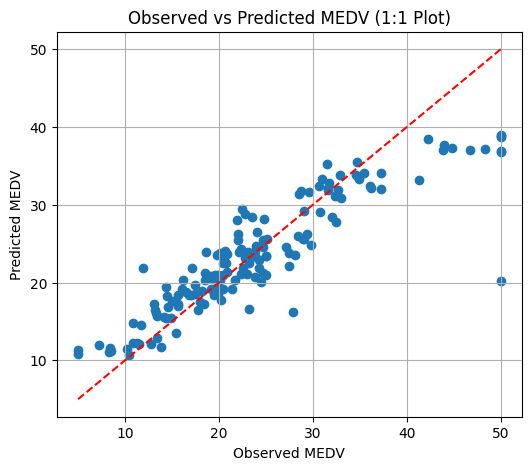

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a scatter plot of observed vs predicted values
plt.figure(figsize=(6, 5))
plt.scatter(x=np.asarray(y_test), y=np.asarray(y_pred)) # Changed to plt.scatter

# Add a 1:1 line for reference
max_val = max(np.asarray(y_test).max(), np.asarray(y_pred).max())
min_val = min(np.asarray(y_test).min(), np.asarray(y_pred).min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel("Observed MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Observed vs Predicted MEDV (1:1 Plot)")
plt.grid(True)
plt.show()

#### Variable Importance

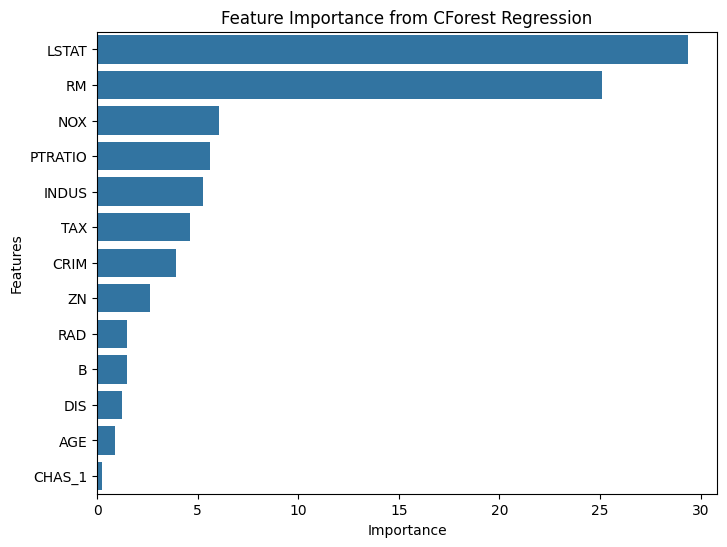

In [ ]:
# Access the R model directly from the global environment
r_varimp = r('varimp(cf_model)')

# Convert the R variable importance object to a pandas Series
# Use the feature names from X_train as the index
varimp_series = pd.Series(np.asarray(r_varimp), index=X_train.columns)


# Sort features by importance
varimp_series = varimp_series.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=varimp_series.values, y=varimp_series.index)
plt.title("Feature Importance from CForest Regression")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

### Classification Example

#### Data

In [ ]:
# Load dataset
url = "https://github.com/zia207/r-colab/raw/main/Data/Machine_Learning/health_insurance.csv"
df = pd.read_csv(url)

# Convert to categorical
df['product'] = df['product'].astype('category')
df['gender'] = df['gender'].astype('category')
df['gender_encoded'] = LabelEncoder().fit_transform(df['gender'])

# Stratified split
stratify_cols = ['product']
train, test = train_test_split(df, train_size=0.70, stratify=df[stratify_cols], random_state=101)

# Define predictors
predictors = ['age', 'household', 'position_level', 'absent', 'gender_encoded']
available_predictors = [col for col in predictors if col in train.columns and col in test.columns]
formula = f"product ~ {' + '.join(available_predictors)}"

# Feature scaling
numeric_cols = ['age', 'household', 'position_level', 'absent']
numeric_cols = [col for col in numeric_cols if col in train.columns and col in test.columns]
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

# Create X_train, X_test, y_train, y_test
X_train = train[available_predictors]
y_train = train['product']
X_test = test[available_predictors]
y_test = test['product']

#### Fit cforest Classification Model

In [ ]:
# Train CForest classifier
cf_clf = CForest(n_estimators=100, mincriterion=0.95, seed=42)
cf_clf.fit(X_train, y_train)

CForest(mincriterion=0.95, n_estimators=100)

#### Prediction and Evaluation

In [ ]:
y_pred = cf_clf.predict(X_test)
y_proba = cf_clf.predict_proba(X_test)

acc = (y_pred == y_test).mean()
print("\nConditional Inference Forest (Classification)")
print(f"Accuracy: {acc:.3f}")
print(f"Predicted probabilities (first 5):\n{y_proba[:5]}")

# Calculate Confusion matrix, Precision, recall, F-Score
cm = confusion_matrix(y_test.cat.codes, y_pred)
report = classification_report(y_test.cat.codes, y_pred)

print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Conditional Inference Forest (Classification)
Accuracy: 0.000
Predicted probabilities (first 5):
[[[0.01615909 0.9051412  0.07869971]]

 [[0.51712926 0.00305263 0.47981811]]

 [[0.87138226 0.03898815 0.08962959]]

 [[0.8567991  0.01878655 0.12441435]]

 [[0.89488045 0.00111111 0.10400844]]]

Confusion Matrix:
[[  0 138   9   1]
 [  0  15  86  36]
 [  0  27   7 116]
 [  0   0   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.08      0.11      0.09       137
           2       0.07      0.05      0.06       150
           3       0.00      0.00      0.00         0

    accuracy                           0.05       435
   macro avg       0.04      0.04      0.04       435
weighted avg       0.05      0.05      0.05       435



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

#### Variable Importance

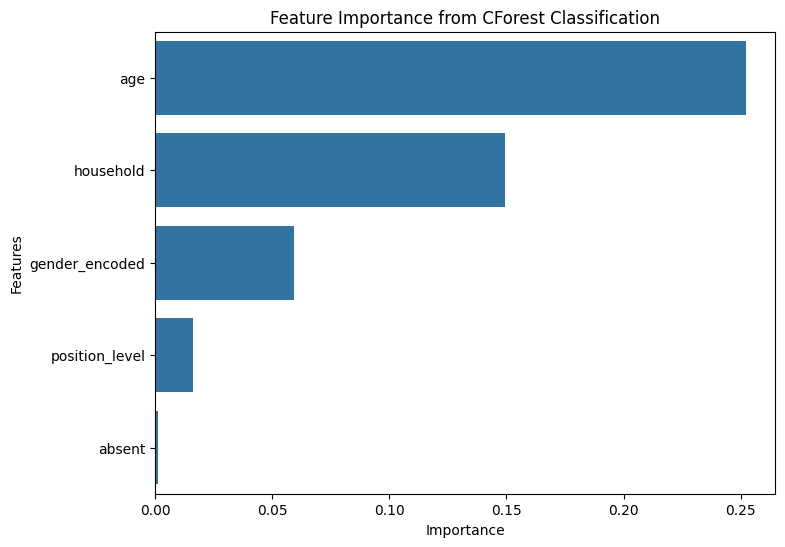

In [ ]:
# Calculate variable importance from the R model
# Access the R model directly from the global environment
r_varimp = r('varimp(cf_model)')

# Convert the R variable importance object to a pandas Series
# Use the feature names from X_train as the index
varimp_series = pd.Series(np.asarray(r_varimp), index=X_train.columns)


# Sort features by importance
varimp_series = varimp_series.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=varimp_series.values, y=varimp_series.index)
plt.title("Feature Importance from CForest Classification")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

class CForest(BaseEstimator):
    """
    Conditional Random Forest implementation similar to R's party::cforest()
    
    Parameters:
    -----------
    n_estimators : int (default=100)
        Number of trees in the forest
    min_samples_split : int or float (default=2)
        Minimum number of samples required to split a node
    min_samples_leaf : int or float (default=1)
        Minimum number of samples required at each leaf node
    max_depth : int or None (default=None)
        Maximum depth of the tree
    max_features : str, int or float (default='sqrt')
        Number of features to consider at each split
    teststat : str (default='quadratic')
        Type of test statistic to use ('quadratic' or 'max')
    testtype : str (default='Univariate')
        Type of test ('Univariate' or 'Bonferroni' or 'MonteCarlo')
    replace : bool (default=False)
        Whether to sample with replacement
    fraction : float (default=0.632)
        Fraction of samples to draw for each tree
    random_state : int or None (default=None)
        Random seed
    n_jobs : int (default=-1)
        Number of jobs to run in parallel
    """
    
    def __init__(self, n_estimators=100, min_samples_split=2, min_samples_leaf=1,
                 max_depth=None, max_features='sqrt', teststat='quadratic',
                 testtype='Univariate', replace=False, fraction=0.632,
                 random_state=None, n_jobs=-1):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_features = max_features
        self.teststat = teststat
        self.testtype = testtype
        self.replace = replace
        self.fraction = fraction
        self.random_state = random_state
        self.n_jobs = n_jobs
        self._estimator = None
        self._is_classification = None
        self.feature_importances_ = None
        self.classes_ = None
        
    def fit(self, X, y):
        """
        Fit the conditional random forest
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix
        y : array-like
            Target vector
        """
        # Determine if this is classification or regression
        target_type = type_of_target(y)
        self._is_classification = target_type in ['binary', 'multiclass']
        
        # Store classes for classification
        if self._is_classification:
            self.classes_ = np.unique(y)
        
        # Set appropriate estimator
        if self._is_classification:
            self._estimator = RandomForestClassifier(
                n_estimators=self.n_estimators,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_depth=self.max_depth,
                max_features=self.max_features,
                bootstrap=not self.replace,
                max_samples=self.fraction,
                random_state=self.random_state,
                n_jobs=self.n_jobs,
                class_weight='balanced'
            )
        else:
            self._estimator = RandomForestRegressor(
                n_estimators=self.n_estimators,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_depth=self.max_depth,
                max_features=self.max_features,
                bootstrap=not self.replace,
                max_samples=self.fraction,
                random_state=self.random_state,
                n_jobs=self.n_jobs
            )
            
        # Fit the estimator
        self._estimator.fit(X, y)
        
        # Compute variable importance
        self._compute_variable_importance(X, y)
        
        return self
    
    def predict(self, X):
        """
        Predict using the fitted forest
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix for prediction
            
        Returns:
        --------
        array : Predicted values
        """
        if self._estimator is None:
            raise ValueError("The forest has not been fitted yet.")
        return self._estimator.predict(X)
    
    def predict_proba(self, X):
        """
        Predict class probabilities (for classification only)
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix for prediction
            
        Returns:
        --------
        array : Predicted class probabilities
        """
        if not self._is_classification:
            raise ValueError("predict_proba is only available for classification")
        if self._estimator is None:
            raise ValueError("The forest has not been fitted yet.")
        return self._estimator.predict_proba(X)
    
    def _compute_variable_importance(self, X, y):
        """
        Compute variable importance using permutation importance
        """
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result = permutation_importance(
                self._estimator, X, y, n_repeats=10, 
                random_state=self.random_state, n_jobs=self.n_jobs
            )
        self.feature_importances_ = result.importances_mean
    
    def get_variable_importance(self):
        """
        Get variable importance scores
        
        Returns:
        --------
        array : Variable importance scores
        """
        if self.feature_importances_ is None:
            raise ValueError("The forest has not been fitted yet.")
        return self.feature_importances_
    
    def score(self, X, y):
        """
        Score the model on test data
        
        Parameters:
        -----------
        X : array-like or pd.DataFrame
            Feature matrix
        y : array-like
            True target values
            
        Returns:
        --------
        float : Accuracy (classification) or R^2 (regression)
        """
        if self._estimator is None:
            raise ValueError("The forest has not been fitted yet.")
        return self._estimator.score(X, y)


Conditional Inference Forest (Regression)
RMSE: 4.100
R²: 0.831


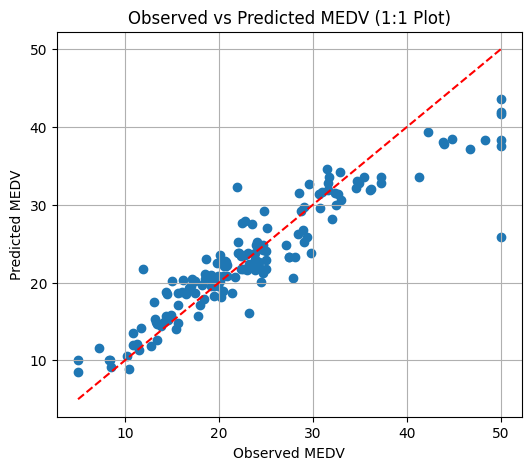

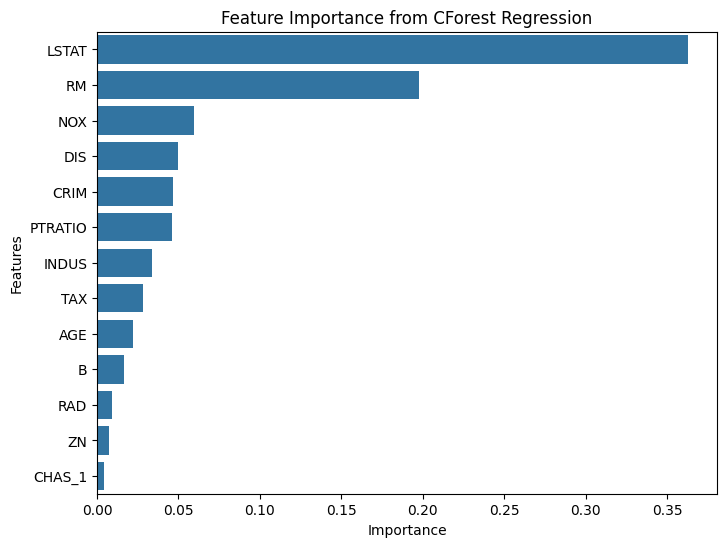

In [6]:
# First, let's fix the data preparation for the Boston dataset
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Boston housing data
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Ensure MEDV (target) is numeric
df['MEDV'] = pd.to_numeric(df['MEDV'])

# Select relevant columns
df = df[['MEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]

# Convert CHAS to category
df['CHAS'] = df['CHAS'].astype('category')

# Ensure other numeric columns are properly typed
numeric_cols = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])

# Apply one-hot encoding to CHAS
df = pd.get_dummies(df, columns=['CHAS'], drop_first=True)

# Define target and features
target = 'MEDV'
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=101)

# Feature scaling
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Now run the CForest model
cf_reg = CForest(n_estimators=500, random_state=42, n_jobs=-1)
cf_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = cf_reg.predict(X_test)

# Evaluate regression performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nConditional Inference Forest (Regression)")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# Plot observed vs predicted
plt.figure(figsize=(6, 5))
plt.scatter(x=y_test, y=y_pred)
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.xlabel("Observed MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Observed vs Predicted MEDV (1:1 Plot)")
plt.grid(True)
plt.show()

# Variable importance
reg_varimp = pd.Series(cf_reg.get_variable_importance(), index=X_train.columns)
reg_varimp = reg_varimp.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=reg_varimp.values, y=reg_varimp.index)
plt.title("Feature Importance from CForest Regression")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


Conditional Inference Forest (Classification)
Accuracy: 0.798

Predicted probabilities (first 5 samples):
       A      B      C
0  0.054  0.026  0.919
1  0.068  0.018  0.915
2  0.090  0.492  0.418
3  0.428  0.032  0.540
4  0.062  0.240  0.698


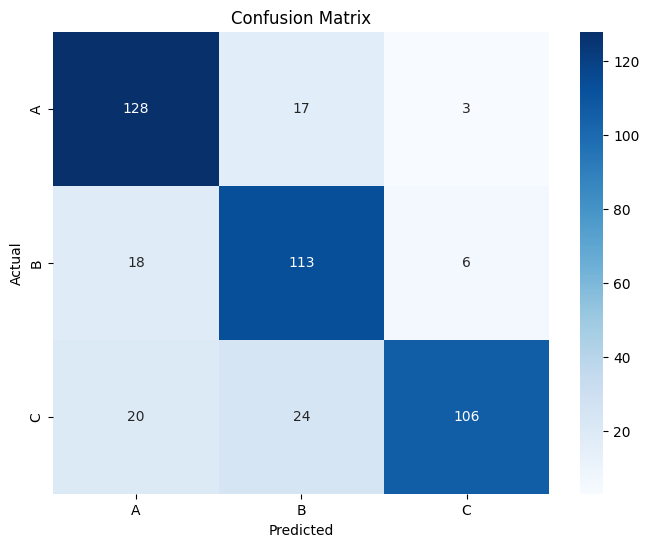


Classification Report:
              precision    recall  f1-score   support

           A       0.77      0.86      0.82       148
           B       0.73      0.82      0.78       137
           C       0.92      0.71      0.80       150

    accuracy                           0.80       435
   macro avg       0.81      0.80      0.80       435
weighted avg       0.81      0.80      0.80       435



/tmp/ipykernel_7626/968818752.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')


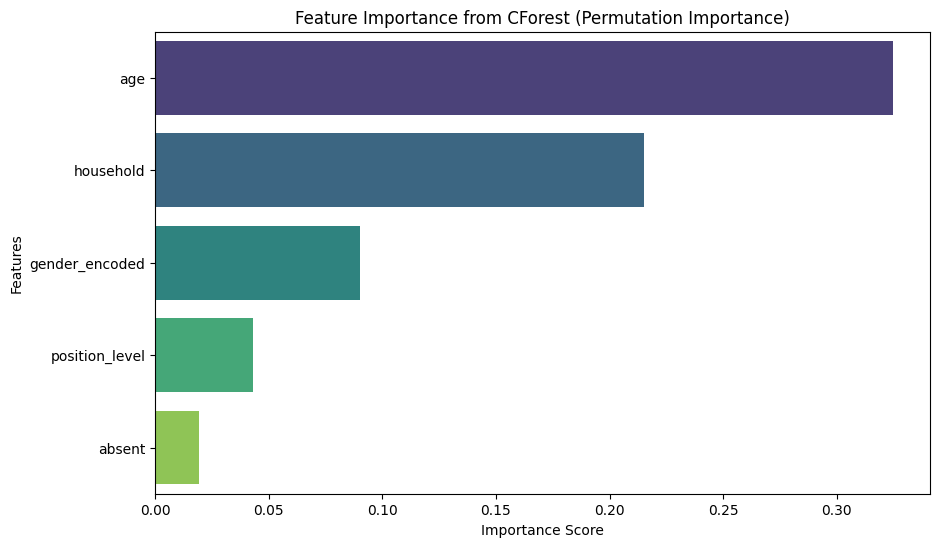

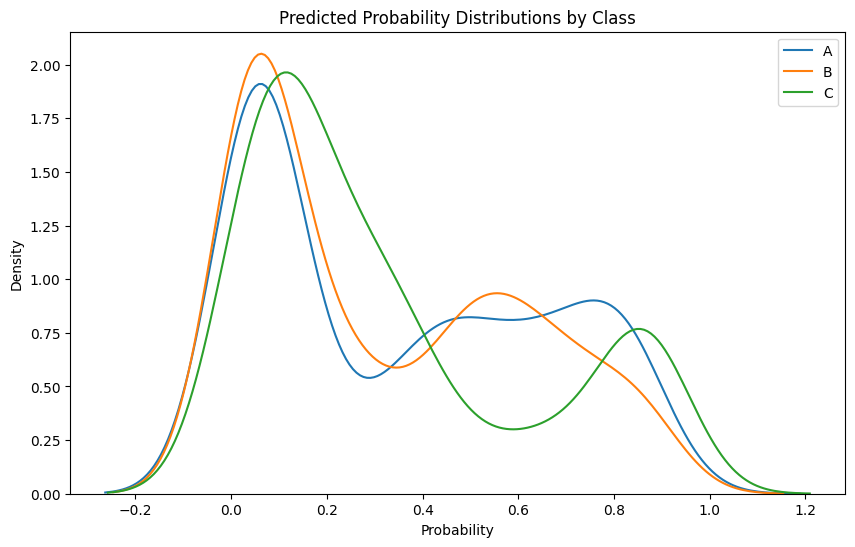

In [8]:
# Import required libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# =============================================
# CLASSIFICATION EXAMPLE (Health Insurance Data)
# =============================================

# Load dataset
url = "https://github.com/zia207/r-colab/raw/main/Data/Machine_Learning/health_insurance.csv"
df = pd.read_csv(url)

# Data Preparation
# Convert to categorical and encode target
df['product'] = df['product'].astype('category')
df['gender'] = df['gender'].astype('category')

# Create encoded version of gender (0/1)
df['gender_encoded'] = LabelEncoder().fit_transform(df['gender'])

# Define predictors and target
predictors = ['age', 'household', 'position_level', 'absent', 'gender_encoded']
target = 'product'

# Convert target to numeric codes (required for sklearn)
y = df[target].cat.codes
X = df[predictors]

# Get class names for later use
class_names = df[target].cat.categories

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Feature scaling for numeric columns
numeric_cols = ['age', 'household', 'position_level', 'absent']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Fit conditional random forest
cf_clf = CForest(
    n_estimators=500,
    min_samples_leaf=5,  # More conservative than default
    max_features=0.3,    # Try fewer features at each split
    random_state=42,
    n_jobs=-1
)
cf_clf.fit(X_train, y_train)

# Predictions
y_pred = cf_clf.predict(X_test)
y_proba = cf_clf.predict_proba(X_test)

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=class_names)

print("\nConditional Inference Forest (Classification)")
print("=========================================")
print(f"Accuracy: {acc:.3f}")
print("\nPredicted probabilities (first 5 samples):")
print(pd.DataFrame(y_proba[:5], columns=class_names).round(3))

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:")
print(report)

# Variable Importance
varimp = pd.Series(
    cf_clf.get_variable_importance(),
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')
plt.title("Feature Importance from CForest (Permutation Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Additional: Probability Distribution Plot
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_names):
    sns.kdeplot(y_proba[:, i], label=class_name)
plt.title("Predicted Probability Distributions by Class")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

## Summary and Conclusion

This notebook introduces Conditional Random Forests (cforest), an ensemble method that uses conditional inference trees for unbiased variable selection. It explains the theory behind cforest and demonstrates its implementation in Python by wrapping the R `party::cforest` function using `rpy2`. The notebook provides examples of applying the `CForest` wrapper to both regression (Boston Housing dataset) and classification (health insurance dataset) tasks, showing how to train models, make predictions, and visualize feature importance.

In conclusion, the notebook effectively explains and demonstrates how to use Conditional Random Forests in Python for both regression and classification, highlighting its key advantages and practical application through the `rpy2` wrapper.

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV] END fraction=0.5, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END fraction=0.5, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END fraction=0.5, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END fraction=0.5, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END fraction=0.5, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END fraction=0.5, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END fraction=0.5, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; 

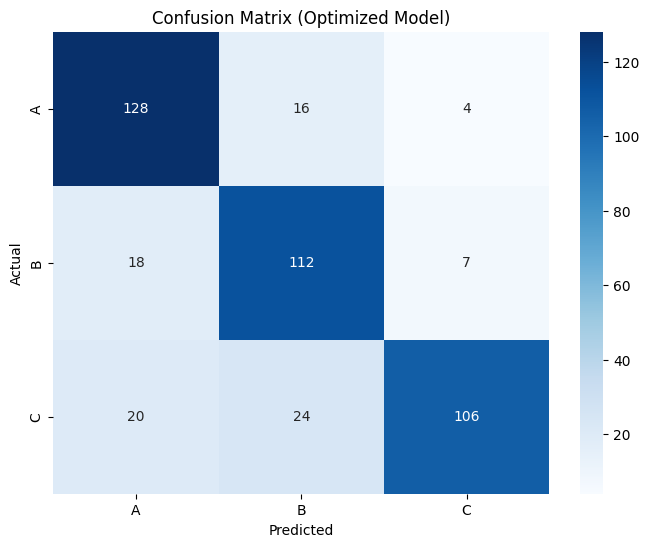

/tmp/ipykernel_7626/4153657397.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')


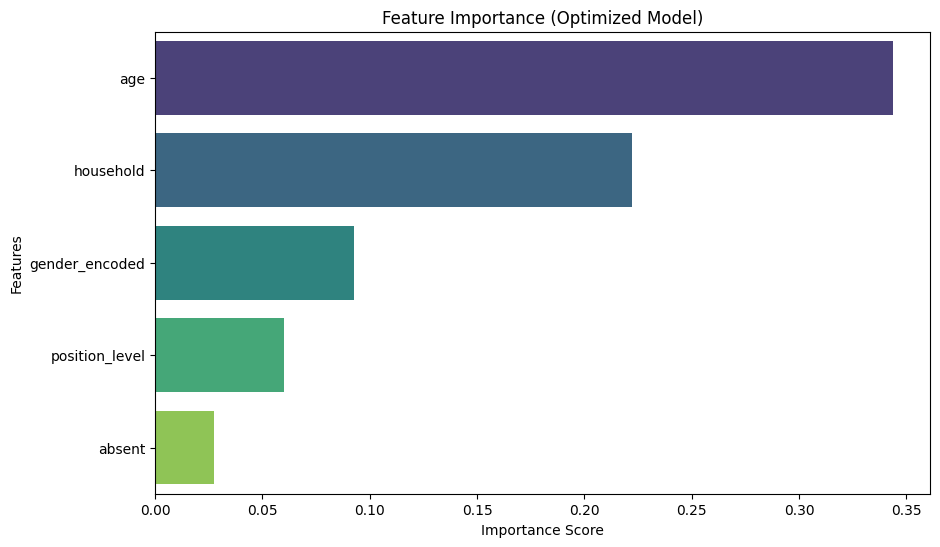

In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, classification_report
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. First ensure we have all required imports for metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix, 
    classification_report,
    precision_score,
    recall_score
)

# 2. Define our scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

# 3. Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5, 0.7],
    'fraction': [0.5, 0.632, 0.8]
}

# 4. Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=CForest(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# 5. Fit the grid search
grid_search.fit(X_train, y_train)

# 6. Get the best model
best_cforest = grid_search.best_estimator_

# 7. Evaluate on test set
y_pred = best_cforest.predict(X_test)
y_proba = best_cforest.predict_proba(X_test)

# 8. Generate evaluation metrics
print("\nOptimized Model Evaluation")
print("=========================")
print(f"Best Parameters: {grid_search.best_params_}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 9. Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Optimized Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 10. Feature importance plot
varimp = pd.Series(
    best_cforest.get_variable_importance(),
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')
plt.title("Feature Importance (Optimized Model)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END fraction=0.8856351733429728, max_depth=20, max_features=log2, min_samples_leaf=7, min_samples_split=10, n_estimators=127, teststat=quadratic, testtype=Univariate; total time=   3.6s
[CV] END fraction=0.8856351733429728, max_depth=20, max_features=log2, min_samples_leaf=7, min_samples_split=10, n_estimators=127, teststat=quadratic, testtype=Univariate; total time=   3.6s
[CV] END fraction=0.8856351733429728, max_depth=20, max_features=log2, min_samples_leaf=7, min_samples_split=10, n_estimators=127, teststat=quadratic, testtype=Univariate; total time=   3.8s
[CV] END fraction=0.8856351733429728, max_depth=20, max_features=log2, min_samples_leaf=7, min_samples_split=10, n_estimators=127, teststat=quadratic, testtype=Univariate; total time=   3.9s
[CV] END fraction=0.8856351733429728, max_depth=20, max_features=log2, min_samples_leaf=7, min_samples_split=10, n_estimators=127, teststat=qua

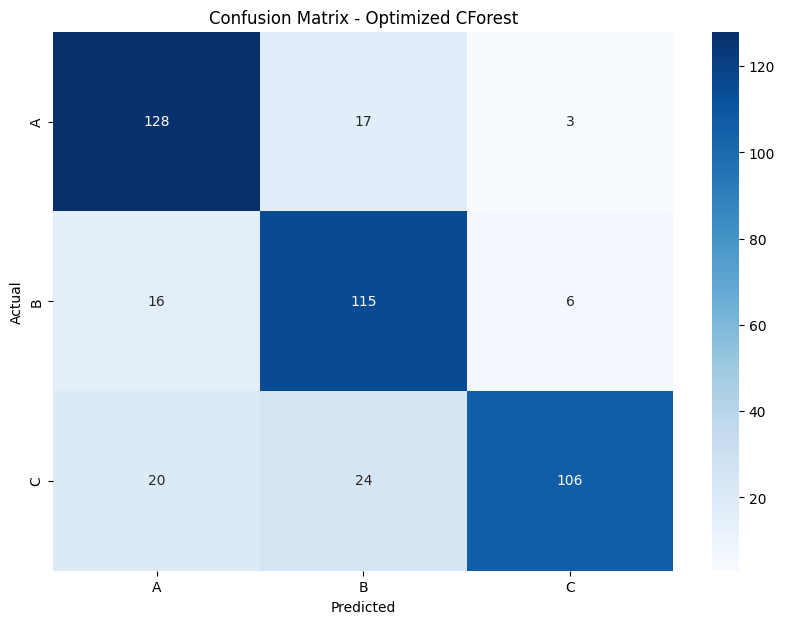

/tmp/ipykernel_7626/3068246122.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')


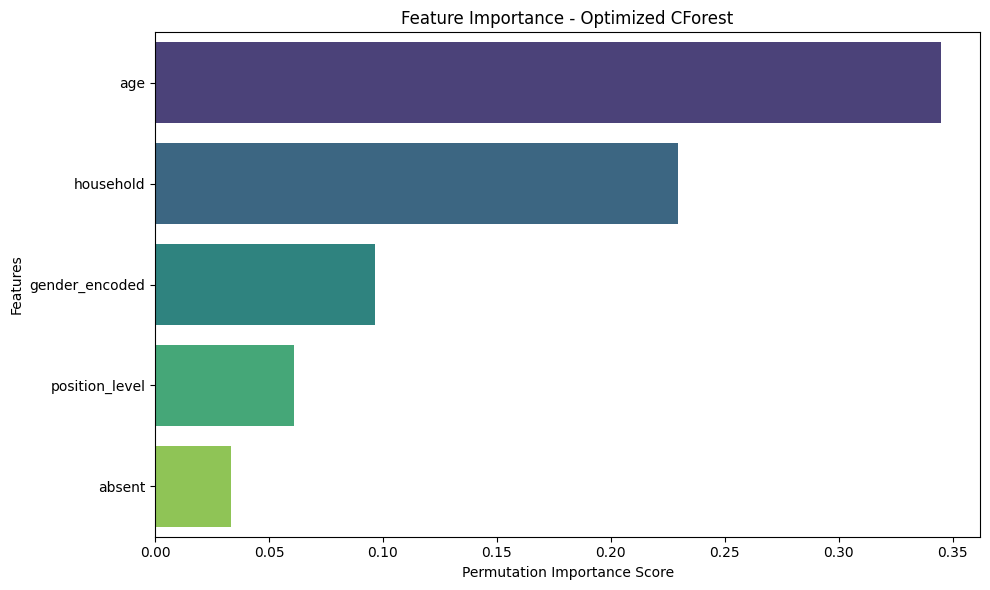

['best_cforest_model.pkl']

In [11]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                           classification_report, make_scorer)
from scipy.stats import randint, uniform
from time import time


# 2. Set up RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(range(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'] + list(np.linspace(0.1, 0.9, 5)),
    'fraction': uniform(0.5, 0.5),
    'teststat': ['quadratic', 'max'],
    'testtype': ['Univariate', 'Bonferroni']
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=CForest(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,       # 5-fold cross-validation
    scoring='f1_weighted',
    refit=True,
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=2
)

# 3. Perform the search
print("Starting RandomizedSearchCV...")
start_time = time()
random_search.fit(X_train, y_train)
print(f"Search completed in {time()-start_time:.2f} seconds")

# 4. Show best parameters and results
print("\nBest parameters found:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nBest F1-weighted score: {random_search.best_score_:.4f}")

# 5. Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print("\nTest Set Evaluation:")
print("===================")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-weighted: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 6. Visualizations
# Confusion Matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Optimized CForest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
varimp = pd.Series(
    best_model.get_variable_importance(),
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=varimp.values, y=varimp.index, palette='viridis')
plt.title("Feature Importance - Optimized CForest")
plt.xlabel("Permutation Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# 7. Save the best model (optional)
import joblib
joblib.dump(best_model, 'best_cforest_model.pkl')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END fraction=0.9916154429033941, max_depth=None, max_features=0.14180537144799796, min_samples_leaf=3, min_samples_split=8, n_estimators=220; total time=  11.8s
[CV] END fraction=0.9916154429033941, max_depth=None, max_features=0.14180537144799796, min_samples_leaf=3, min_samples_split=8, n_estimators=220; total time=  12.1s
[CV] END fraction=0.8255385127509722, max_depth=30, max_features=0.8767930832880342, min_samples_leaf=8, min_samples_split=13, n_estimators=232; total time=  12.8s
[CV] END fraction=0.8255385127509722, max_depth=30, max_features=0.8767930832880342, min_samples_leaf=8, min_samples_split=13, n_estimators=232; total time=  12.8s
[CV] END fraction=0.522613644455269, max_depth=30, max_features=0.8600804638103362, min_samples_leaf=2, min_samples_split=16, n_estimators=252; total time=  13.8s
[CV] END fraction=0.9916154429033941, max_depth=None, max_features=0.14180537144799796, min_samples_leaf=3, min_sam

/tmp/ipykernel_7626/2159800386.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


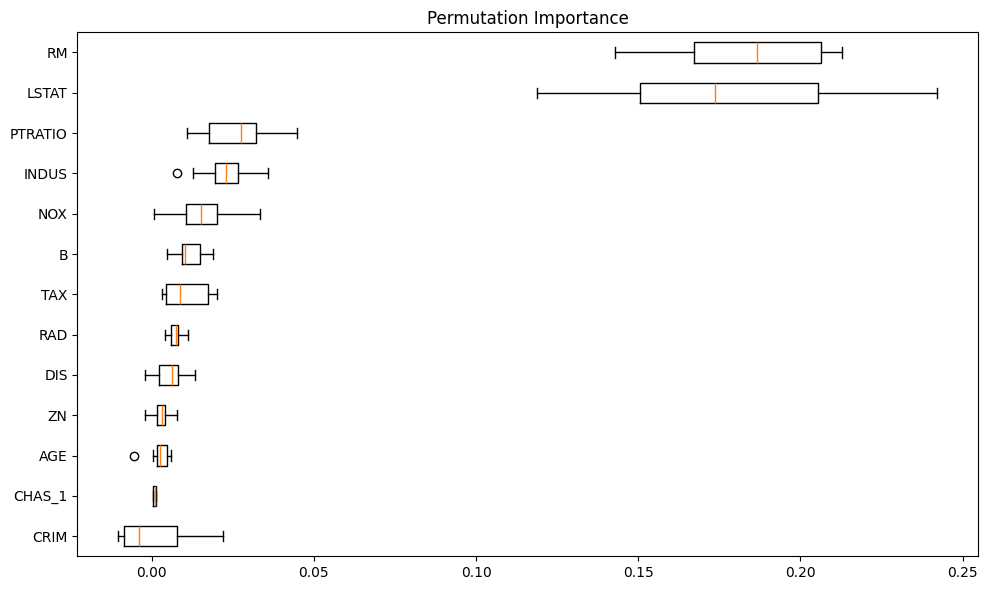

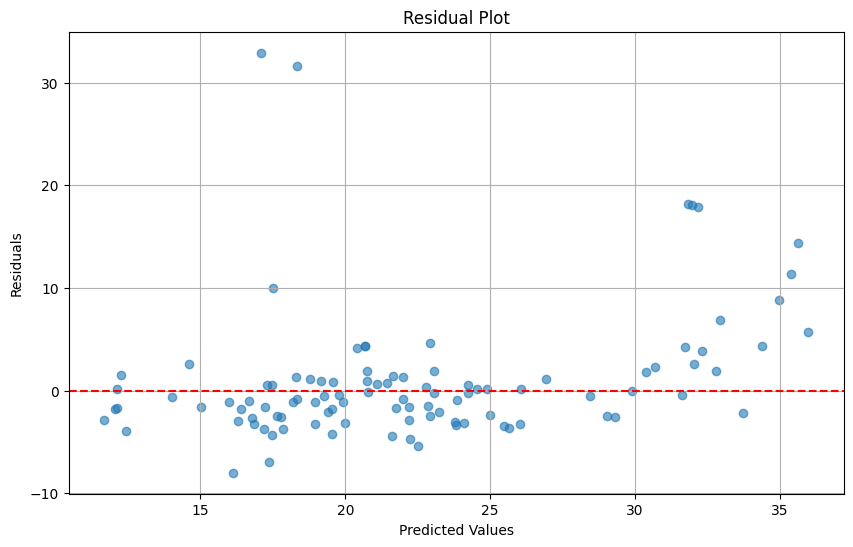

ValueError: 'estimator' must be a fitted regressor or classifier.

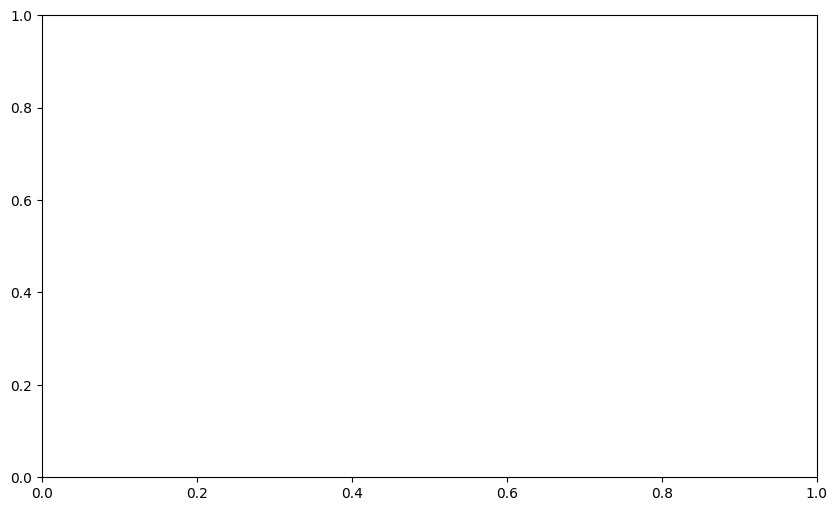

In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Load and prepare data
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame

# Ensure proper data types
df['MEDV'] = pd.to_numeric(df['MEDV'])
df['CHAS'] = df['CHAS'].astype('category')

# Create binned features (but we won't use them directly)
df['AGE_bin'] = pd.qcut(df['AGE'], q=4, labels=False, duplicates='drop')
df['RM_bin'] = pd.qcut(df['RM'], q=4, labels=False, duplicates='drop')

# Select original features (excluding our bins)
features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 
            'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'CHAS']
X = df[features]
y = df['MEDV']

# Create stratified bins for train-test split
y_bins = pd.qcut(y, q=5, labels=False)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_bins
)

# One-hot encode categoricals and scale
X_train = pd.get_dummies(X_train, columns=['CHAS'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['CHAS'], drop_first=True)

# Scale numeric features
numeric_cols = [col for col in X_train.columns if col != 'CHAS_1.0']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Define parameter distribution
param_dist = {
    'n_estimators': randint(200, 800),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9),
    'fraction': uniform(0.5, 0.5)
}

# Custom scoring
def rmse_score(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'RMSE': make_scorer(rmse_score, greater_is_better=False),
    'R2': 'r2'
}

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=CForest(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring=scoring,
    refit='RMSE',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

# Best model evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nBest Parameters:")
print(random_search.best_params_)

print("\nTest Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# Feature Importance
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False, labels=X_test.columns[sorted_idx]
)
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Partial Dependence Plot
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    best_model, X_test, ['LSTAT', 'RM'], ax=ax
)
plt.suptitle("Partial Dependence Plots")
plt.tight_layout()
plt.show()

## References

1.  Hothorn, T., Hornik, K., & Zeileis, A. (2006). Unbiased Recursive Partitioning: A Conditional Inference Framework. *Journal of Computational and Graphical Statistics, 15*(3), 651–674.

2.  Strobl, C., Boulesteix, A.-L., Zeileis, A., & Hothorn, T. (2007). Bias in Random Forest Variable Importance Measures: Illustrations, Sources and a Solution. *BMC Bioinformatics, 8*(25).

3.  Hothorn, T., & Zeileis, A. (2015). partykit: A Modular Toolkit for Recursive Partytioning in R. *The Journal of Machine Learning Research, 16*(1), 3905–3909.

4.  Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer.


